Import The Necessary Packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import io
from google.colab import files
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn import neighbors
from sklearn.svm import SVR
from warnings import filterwarnings
filterwarnings('ignore')
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn import model_selection 
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
uploaded = files.upload()        #google colab üzerinde yapılan çalışma olduğu için veri setimi içeriye yüklüyorum
df=pd.read_csv(io.BytesIO(uploaded['turkey_car_market.csv']))

Saving turkey_car_market.csv to turkey_car_market (3).csv


In [ ]:
df.shape

(9044, 15)

In [ ]:
df.head()

,İlan Tarihi,Marka,Arac Tip Grubu,Arac Tip,Model Yıl,Yakıt Turu,Vites,CCM,Beygir Gucu,Renk,Kasa Tipi,Kimden,Durum,Km,Fiyat
0,27/05/2020,Jaguar,XF,2.0 D Prestige Plus,2017.0,Dizel,Otomatik Vites,1801-2000 cc,176-200 BG,Lacivert,Hatchback 5 Kapı,Galeriden,2. El,26100,634500
1,16/06/2020,Acura,CL,-,2015.0,Dizel,Yarı Otomatik Vites,1301-1600 cc,101-125 BG,Mavi,Sedan,Sahibinden,2. El,127000,151500
2,14/06/2020,Acura,CL,2.2,1994.0,Benzin/LPG,Düz Vites,1301-1600 cc,101-125 BG,Turkuaz,Sedan,Sahibinden,2. El,175000,19750
3,11/06/2020,Acura,CL,-,2013.0,Dizel,Düz Vites,1301-1600 cc,76-100 BG,Kahverengi,Sedan,Sahibinden,2. El,325,52000
4,11/06/2020,Acura,CL,2.2,2010.0,Dizel,Otomatik Vites,1801-2000 cc,151-175 BG,Beyaz,Sedan,Sahibinden,2. El,207000,148750


Eksik veri Kontrolu yapalım

In [ ]:
df.isnull().sum()

İlan Tarihi       0
Marka             0
Arac Tip Grubu    0
Arac Tip          0
Model Yıl         0
Yakıt Turu        0
Vites             0
CCM               0
Beygir Gucu       0
Renk              0
Kasa Tipi         0
Kimden            0
Durum             0
Km                0
Fiyat             0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9044 entries, 0 to 9043
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   İlan Tarihi     9044 non-null   object 
 1   Marka           9044 non-null   object 
 2   Arac Tip Grubu  9044 non-null   object 
 3   Arac Tip        9044 non-null   object 
 4   Model Yıl       9044 non-null   float64
 5   Yakıt Turu      9044 non-null   object 
 6   Vites           9044 non-null   object 
 7   CCM             9044 non-null   object 
 8   Beygir Gucu     9044 non-null   object 
 9   Renk            9044 non-null   object 
 10  Kasa Tipi       9044 non-null   object 
 11  Kimden          9044 non-null   object 
 12  Durum           9044 non-null   object 
 13  Km              9044 non-null   int64  
 14  Fiyat           9044 non-null   int64  
dtypes: float64(1), int64(2), object(12)
memory usage: 1.0+ MB


## Verimizi Görselleştirelim

1- Yakıt Türüne Göre Araç Fiyatlarına bakalım

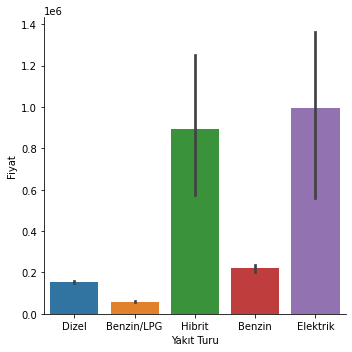

In [ ]:
sns.catplot(x="Yakıt Turu", y="Fiyat", kind="bar", data=df);

2-Vites Türüne Göre Araç Fiyatları

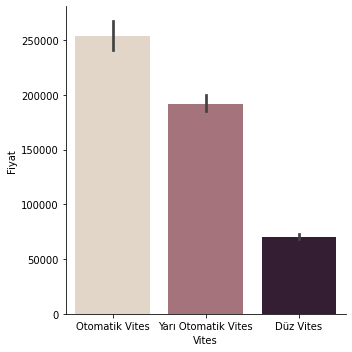

In [ ]:
sns.catplot(x="Vites", y="Fiyat", kind="bar", data=df, palette="ch:.25");

3- Araç Durumuna Göre Fiyatlar

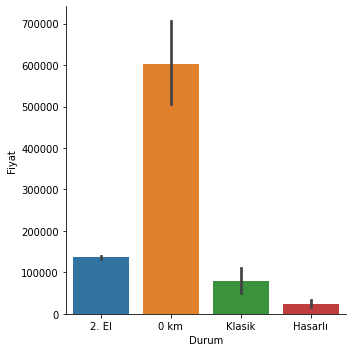

In [ ]:
sns.catplot(x="Durum", y="Fiyat", kind="bar", data=df);

Görüldüğü üzere 0 km araçların fiyatlarında çok büyük bir fark var. Bir de satıcıya göre fiyatları inceleyelim

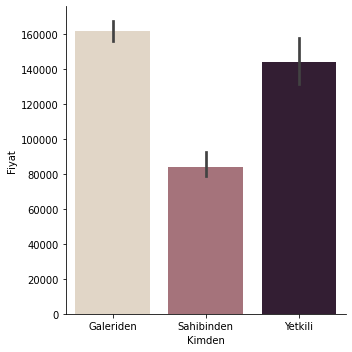

In [ ]:
sns.catplot(x="Kimden", y="Fiyat", kind="bar", data=df, palette="ch:.25");

## Kolonları inceleyelim

Kolonlarlardaki benzersiz kaç kategorik veri var bunları inceleyeceğiz

In [ ]:
print(len(df['Marka'].unique()))               
markalar=df['Marka'].unique()
print(markalar)

36
['Jaguar' 'Acura' 'Jeep' 'Hyundai' 'Alfa Romeo' 'Audi' 'Mercedes'
 'Volkswagen' 'Land Rover' 'BMW' 'Dacia' 'Renault' 'Peugeot' 'Chevrolet'
 'Chery' 'Citroen' 'Chrysler' 'Fiat' 'Ford' 'Honda' 'Geely' 'Infiniti'
 'Isuzu' 'Kia' 'Lada' 'Maserati' 'Mazda' 'Mini' 'Mitsubishi' 'Nissan'
 'Opel' 'Porsche' 'Rover' 'Seat' 'Skoda' 'Tofaş']


In [ ]:
print(len(df['Arac Tip'].unique()))
car_type=df['Arac Tip'].unique()
print(car_type)

1759
['2.0 D Prestige Plus' '-' '2.2' ... 'SLX ie' 'SL' 'L']


" - " ile tanımlanmış bir araç tipi var. Bu modelimiz için uygun bir veri değil. Bu veriden kaç tane olduğunu öğrenelim ve ilerleyen adımlarda üzerinde ona göre işlem yapalım

In [ ]:
len(df[df['Arac Tip']=='-'])  

55

In [ ]:
print(len(df['Yakıt Turu'].unique()))
yakıt_type=df['Yakıt Turu'].unique()
yakıt_type

5


array(['Dizel', 'Benzin/LPG', 'Hibrit', 'Benzin', 'Elektrik'],
      dtype=object)

In [ ]:
print(len(df['Vites'].unique()))
vites_type=df['Vites'].unique()
vites_type

3


array(['Otomatik Vites', 'Yarı Otomatik Vites', 'Düz Vites'], dtype=object)

Araç Tipi Kolonunda olduğu gibi Beygir Gücü ve CCM kolonlarında da uygun olmayan veriler mevcut. Bunlarında sayısını öğrenelim.

In [ ]:
print('Farklı CCM değer sayısı : ', len(df['CCM'].unique()),'\n')
CCM_type=df['CCM'].unique()
print(CCM_type,'\n')
print('Bilmiyorum değeri girilmiş CCM sayısı : ', len(df[df['CCM']=='Bilmiyorum']))

Farklı CCM değer sayısı :  15 

['1801-2000 cc' '1301-1600 cc' '1601-1800 cc' '1300 cc ve altı'
 '2501-3000 cc' 'Bilmiyorum' '2001-2500 cc' '3501-4000 cc' '3001-3500 cc'
 '4001-4500 cc' '-' '6001 cc ve üzeri' '5501-6000 cc' '5001-5500 cc'
 '4501-5000 cc'] 

Bilmiyorum değeri girilmiş CCM sayısı :  108


In [ ]:
print('Farklı Beygir gucu değer sayısı : ', len(df['Beygir Gucu'].unique()),'\n')
power=df['Beygir Gucu'].unique()
print(power,'\n')
print('Bilmiyorum değeri girilmiş Beygir Gucu sayısı : ', len(df[df['Beygir Gucu']=='Bilmiyorum']))

Farklı Beygir gucu değer sayısı :  19 

['176-200 BG' '101-125 BG' '76-100 BG' '151-175 BG' '100 BG ve altı'
 '201-225 BG' '126-150 BG' 'Bilmiyorum' '276-300 BG' '226-250 BG'
 '251-275 BG' '301-325 BG' '326-350 BG' '376-400 BG' '51-75 BG' '-'
 '601 BG ve üzeri' '50 BG ve altı' '451-475 BG'] 

Bilmiyorum değeri girilmiş Beygir Gucu sayısı :  5549


Araçların Model Yılı yerine yaşlarıyla işlem yapmak bize daha kolaylık sağlayacaktır. Buna Göre bir kolon oluşturalım

In [ ]:
df['car_age']=2020-df['Model Yıl']     #modelin yılı yerine yaşı ile işlem yapıcağız
df['car_age'].head()

0     3.0
1     5.0
2    26.0
3     7.0
4    10.0
Name: car_age, dtype: float64

Yaş değişkenini oluşturduğumuz için Model Yılını artık silebiliriz. Bütün araçlarında aynı yıl içinde ilan verildiğini düşünürsek işlem kolaylığı açısından İlan tarihinide silebiliriz

In [ ]:
df.drop(['Model Yıl'], axis=1,inplace=True)    #işimize yaramayan kolonları siliyoruz
df.drop(['İlan Tarihi'],axis=1,inplace=True)
df.columns

Index(['Marka', 'Arac Tip Grubu', 'Arac Tip', 'Yakıt Turu', 'Vites', 'CCM',
       'Beygir Gucu', 'Renk', 'Kasa Tipi', 'Kimden', 'Durum', 'Km', 'Fiyat',
       'car_age'],
      dtype='object')

## Uygun olmayan Verileri Temizleme

Öncelikle araç tipindeki '-' ile girilmiş verileri düzenleyeceğiz. Bu şekilde az sayıda veri var. Ancak bu kolonda çeşitlilik çok fazla olduğundan dolayı bu verileri silmek yerine 'diğer' adlı bir değişkene atacağız. 

In [ ]:
df['Arac Tip']=df['Arac Tip'].str.replace('-','Diger')
len(df[df['Arac Tip']=='Diger'])

55

CCM kolonunda da 'Bilmiyorum' değeri girilmiş 108 tane verimiz bulunuyordu. Datasetimizin büyüklüğün düşünürsek bu değerleri silmek modelimizi çok fazla etkilemeyecektir. Çeşitlilik az olduğundan dolayı doldurma işlemide yapmamız modelimizin başka tarafa kaymasına sebep olabilir.

In [ ]:
CCM_drop=df[df['CCM']=='Bilmiyorum'].index
df.drop(CCM_drop,axis=0,inplace=True)

NOT: Beygir Gücü kolonunda 5549 adet Bilmiyorum değeri girilmiş kolon bulunuyordu. Bu kolonları En yakın komşularına göre(KNN) biraz sonra doldurma işlemi yapacağız.

In [ ]:
df.shape

(8936, 14)

Kategorik Değerleri Modelimize vermek için sayısal forma döndüreceğiz
## Label Encoder

İlk önce Araba Markalarını sayısal forma döndürüp daha sonra hangi sayının hangi modele denk geldiğini tablo şeklinde göstereceğiz

In [ ]:
l_encoder1=LabelEncoder()
df['Marka']=l_encoder1.fit_transform(df['Marka'])

In [ ]:
cars={}
car_name = list(l_encoder1.inverse_transform([i for i in range(35)]))
for i,x in enumerate(car_name):
  if i not in cars.keys():
    cars[i] =x

In [ ]:
pd.DataFrame(cars.items(), columns=['label_values', 'car_name']).head()

,label_values,car_name
0,0,Acura
1,1,Alfa Romeo
2,2,Audi
3,3,BMW
4,4,Chevrolet


Kalan Diğer Değişkenlerede Label Encoder işlemini uyguluyoruz

In [ ]:
l_encoder = LabelEncoder()
columns = ['Arac Tip Grubu', 'Arac Tip','Yakıt Turu', 'Vites', 'CCM', 'Beygir Gucu', 'Renk', 'Kasa Tipi','Kimden', 'Durum']
for i in columns:
  df[i]=l_encoder.fit_transform(df[i])

In [ ]:
df.head()

,Marka,Arac Tip Grubu,Arac Tip,Yakıt Turu,Vites,CCM,Beygir Gucu,Renk,Kasa Tipi,Kimden,Durum,Km,Fiyat,car_age
0,15,374,1082,2,1,4,5,17,5,0,1,26100,634500,3.0
1,0,126,1612,2,2,2,2,18,9,1,1,127000,151500,5.0
2,0,126,1171,1,0,2,2,23,9,1,1,175000,19750,26.0
3,0,126,1612,2,0,2,17,13,9,1,1,325,52000,7.0
4,0,126,1171,2,1,4,4,4,9,1,1,207000,148750,10.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 0 to 9043
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Marka           8936 non-null   int64  
 1   Arac Tip Grubu  8936 non-null   int64  
 2   Arac Tip        8936 non-null   int64  
 3   Yakıt Turu      8936 non-null   int64  
 4   Vites           8936 non-null   int64  
 5   CCM             8936 non-null   int64  
 6   Beygir Gucu     8936 non-null   int64  
 7   Renk            8936 non-null   int64  
 8   Kasa Tipi       8936 non-null   int64  
 9   Kimden          8936 non-null   int64  
 10  Durum           8936 non-null   int64  
 11  Km              8936 non-null   int64  
 12  Fiyat           8936 non-null   int64  
 13  car_age         8936 non-null   float64
dtypes: float64(1), int64(13)
memory usage: 1.0 MB


Yukarıda Bahsettiğim Beygir Gücü Kolonunu doldurma zamanı geldi. 


Label Encoder işlemi uyguladığımız için şuanda ***"Bilmiyorum"*** değerine sahip verinin karşılı 18. İlk önce Bunları NaN formuna döndürüyoruz

In [ ]:
df['Beygir Gucu']=df['Beygir Gucu'].replace(18,np.nan)  
df.isnull().sum()

Marka                0
Arac Tip Grubu       0
Arac Tip             0
Yakıt Turu           0
Vites                0
CCM                  0
Beygir Gucu       5484
Renk                 0
Kasa Tipi            0
Kimden               0
Durum                0
Km                   0
Fiyat                0
car_age              0
dtype: int64

Şimdi de bu Nan Değere sahip verileri KNNImputer kullanarak 5 komşu sayısına göre dolduracağız

In [ ]:
imputer = KNNImputer(n_neighbors=5)
df['Beygir Gucu']=imputer.fit_transform(df[['Beygir Gucu']])
df.isnull().sum()

Marka             0
Arac Tip Grubu    0
Arac Tip          0
Yakıt Turu        0
Vites             0
CCM               0
Beygir Gucu       0
Renk              0
Kasa Tipi         0
Kimden            0
Durum             0
Km                0
Fiyat             0
car_age           0
dtype: int64

In [ ]:
df['Beygir Gucu'] = round(df['Beygir Gucu'])   #doldururken float olarak bıraktığı için tam değere yuvarlıyorum

## Aykırı değerleri Silmek

In [ ]:
q1 = df["Fiyat"].quantile(0.25)
q3 = df["Fiyat"].quantile(0.75)      

IOC = q3 - q1

alt_sınır = q1 - 1.5*IOC
üst_sınır = q3 + 1.5*IOC

sınır = (df["Fiyat"] < alt_sınır) | (df["Fiyat"] > üst_sınır)
df["Aykırı_Deger"] = sınır
print('Aykırı Değer Sayısı =>\n',df["Aykırı_Deger"].value_counts())
df = df.loc[df["Aykırı_Deger"] == False]
del df["Aykırı_Deger"]

Aykırı Değer Sayısı =>
 False    8189
True      747
Name: Aykırı_Deger, dtype: int64


In [ ]:
y=df['Fiyat']
x=df.drop(['Fiyat'],axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)
x_train.head()

,Marka,Arac Tip Grubu,Arac Tip,Yakıt Turu,Vites,CCM,Beygir Gucu,Renk,Kasa Tipi,Kimden,Durum,Km,car_age
4243,19,192,1746,0,2,4,7.0,4,0,0,1,76000,7.0
2447,9,190,888,2,0,7,17.0,4,9,0,1,130000,5.0
2332,8,255,553,1,0,2,2.0,11,9,1,1,216000,16.0
3417,12,382,59,1,0,1,15.0,11,5,1,1,111000,9.0
539,3,41,1304,0,1,3,3.0,9,9,0,1,50000,5.0


Verilerimizi sayısal forma döndürdük ancak hepsi farklı aralıklarda değer alıyor. Bunları daha düzenli şekilde modelimize vermeliyiz. Bu yüzden kolonlarımıza Standard Scaler işlemi uygulayacağız

In [ ]:
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.transform(x_test)

Veri setimizi ayırdık. şimdi modelimizi eğitme sırası geldi. ancak hangi modeli kullanarak eğiticeğimize karar vermemiz gerekiyor. bu yüzden tüm modelleri sırayla deneyen bir fonksiyon yazıyoruz. Bu fonksiyon dışardan(verdiğimiz listeden) aldığı fonksiyonları tek tek deniyor ve ekrana model score ve mean squared error değerini yazıyor. Buradan elde edeceğimiz değere göre hangi model üzerinden ilerleyeceğimizi seçeceğiz.

In [ ]:
modeller=[]
scores=[]
def compML(alg,x_train,y_train,x_test,y_test):
    model=alg().fit(x_train,y_train)
    y_pred=model.predict(x_test)
    RMSE= np.sqrt(mean_squared_error(y_test,y_pred))
    model_ismi= alg.__name__
    model_score = model.score(x_test,y_test)
    scores.append(model_score*100 if model_score > 0 else 0)
    modeller.append(model_ismi)
    print(model_ismi ," Modeli Test Hatası => ", RMSE,' |  Model Score => ', model_score*100)

models=[LGBMRegressor, Lasso,
        XGBRegressor, LinearRegression,
        GradientBoostingRegressor,
        RandomForestRegressor, ElasticNet,
        DecisionTreeRegressor, Ridge,
        MLPRegressor,
        KNeighborsRegressor, 
        SVR]

for i in models:
    compML(i,x_train,y_train,x_test,y_test) 

LGBMRegressor  Modeli Test Hatası =>  14831.18488609659  |  Model Score =>  93.9174304981272
Lasso  Modeli Test Hatası =>  35395.81300803671  |  Model Score =>  65.35511161271837
[16:19:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor  Modeli Test Hatası =>  20481.764326106415  |  Model Score =>  88.39967620847757
LinearRegression  Modeli Test Hatası =>  35395.83346156064  |  Model Score =>  65.3550715735048
GradientBoostingRegressor  Modeli Test Hatası =>  20503.133059996024  |  Model Score =>  88.37545822240412
RandomForestRegressor  Modeli Test Hatası =>  16051.171717280013  |  Model Score =>  92.87559066335173
ElasticNet  Modeli Test Hatası =>  37556.190703509055  |  Model Score =>  60.99696042757766
DecisionTreeRegressor  Modeli Test Hatası =>  22527.73014855047  |  Model Score =>  85.9663625442339
Ridge  Modeli Test Hatası =>  35395.75611704879  |  Model Score =>  65.35522298071224
MLPRegressor  M

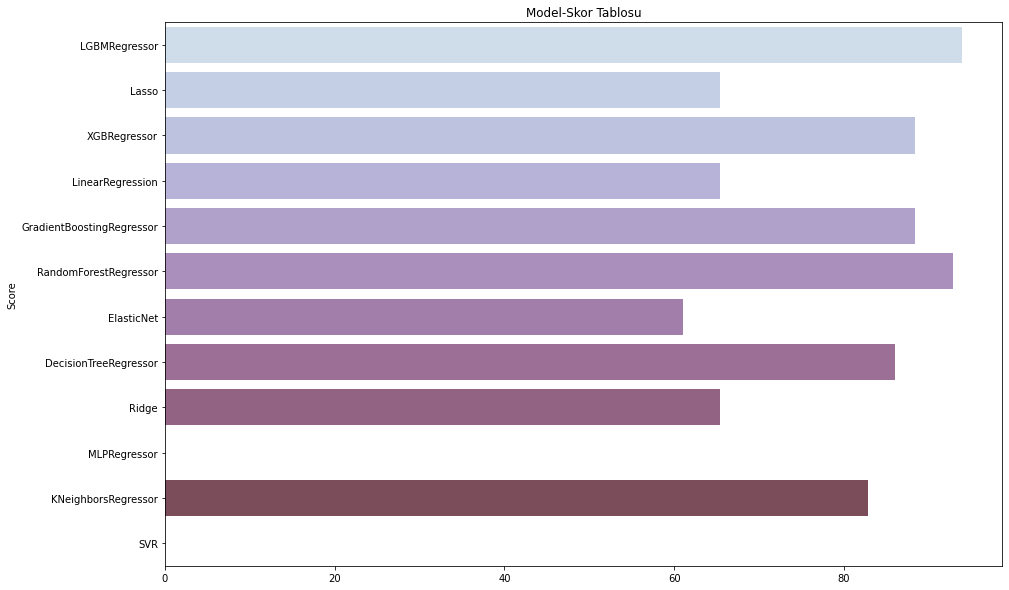

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x=scores, y=modeller, palette="ch:4.5,-.7,dark=.3")
ax.set_title("Model-Skor Tablosu")
ax.set_ylabel("Modeller")
ax.set_ylabel("Score")
plt.show()

İlkel Eğitim aşamasını tamamlamış olduk. Buna Göre En iyi sonuçları LightGBM gösterdi. Bu model üzerinden ilerleyeceğiz ve model tuning işlemi gerçekleştireceğiz.

In [ ]:
lgbm=LGBMRegressor()     
lgbm.fit(x_train,y_train)

lgbm_pred = lgbm.predict(x_test)

model_score = lgbm.score(x_test,y_test)
r2_skor = r2_score(y_test, lgbm_pred)
hata_skor = np.sqrt(mean_squared_error(y_test, lgbm_pred))
ev = metrics.explained_variance_score(y_test, lgbm_pred)

print("Model Score: ", model_score*100)
print("R2_skoru: ", r2_skor)
print("Hata Kare: ", hata_skor)
print("Explained Variance : ", ev)

Model Score:  93.9174304981272
R2_skoru:  0.9391743049812722
Hata Kare:  14831.18488609659
Explained Variance :  0.9391743241100291


Modelimizi optimize etmek için bir çok hiperparametre deneyeceğiz. Burada hangi değereri denemek istediğimizi bir dict formatında GridSearchCV fonksiyonuna veriyoruz

In [ ]:
lgbm_params={'learning_rate':[0.01, 0.1, 0.5],   
            'n_estimators':[200,500,1000],
            'max_depth':[5, 7, 10],
             'colsample_bytree':[0.7, 0.9, 1.0],
             'subsample': [0.5, 0.7, 0.6, 0.4]
             }
lgbm_cv_model=GridSearchCV(lgbm,lgbm_params,cv=10,n_jobs=-1,verbose=2).fit(x_train,y_train)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 30.0min finished


In [ ]:
lgbm_cv_model.best_params_

{'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 500,
 'subsample': 0.5}

Model Tuning işlemimiz tamamlandı. En iyi parametrelere ulaştık. şimdi bunları modelimize vererek tekrardan eğiteceğiz. Böylelikle optimize final modelimize ulaşmış olacağız

In [ ]:
lgbm_tuned=LGBMRegressor(learning_rate = lgbm_cv_model.best_params_['learning_rate'],
                        max_depth = lgbm_cv_model.best_params_['max_depth'],
                        n_estimators = lgbm_cv_model.best_params_['n_estimators'],
                        colsample_bytree = lgbm_cv_model.best_params_['colsample_bytree'],
                        subsample=lgbm_cv_model.best_params_['subsample']).fit(x_train,y_train)

y_pred=lgbm_tuned.predict(x_test)

model_score = lgbm_tuned.score(x_test,y_test)
r2_skor = r2_score(y_test, y_pred)
hata_skor = np.sqrt(mean_squared_error(y_test, y_pred))
adjusted_r2_skor = 1 - (1-r2_skor)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
ev = metrics.explained_variance_score(y_test, y_pred)

print("Model scoru : ", model_score*100)
print("R2_skoru: ", r2_skor)
print("Hata Kare: ", hata_skor)
print("Adjusted_R2_skoru : ", adjusted_r2_skor)
print("Explained Variance : ", ev)

Model scoru :  94.72769638319976
R2_skoru:  0.9472769638319976
Hata Kare:  13808.05521076068
Adjusted_R2_skoru :  0.9468549198232635
Explained Variance :  0.9472886515936138


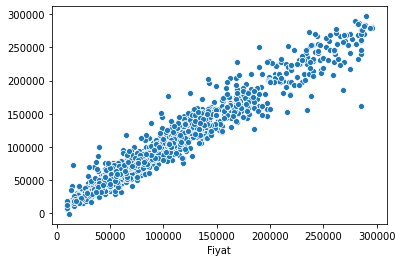

In [ ]:
sns.scatterplot(x=y_test,y=y_pred)

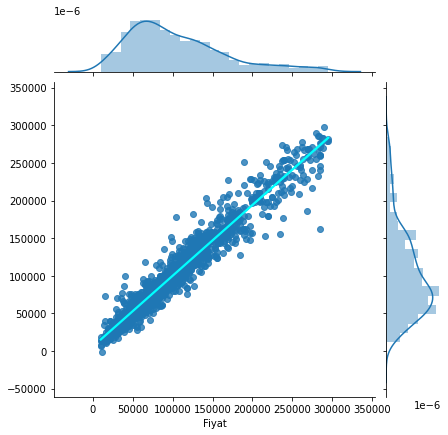

In [ ]:
sns.jointplot(x=y_test, y=y_pred,  kind='reg',
                  joint_kws={'line_kws':{'color':'cyan'}})

## Gerçek Değerler ile Tahminler Arasındaki 10 aracın tablosu

In [ ]:
sonuc = pd.DataFrame({'Gerçek Değerler': np.array(y_test).flatten(), 'Tahminler': y_pred.flatten(),'Fark':np.array(y_test).flatten()-y_pred.flatten()})
sonuc.Fark=round(sonuc.Fark)
sonuc.head(10)

,Gerçek Değerler,Tahminler,Fark
0,60000,53726.354250,6274.0
1,79750,83099.037386,-3349.0
2,64000,67548.646150,-3549.0
3,55900,56456.296692,-556.0
4,79000,57827.140995,21173.0
5,44500,39282.070928,5218.0
6,197000,156586.266330,40414.0
7,57500,48863.425295,8637.0
8,76000,75784.045810,216.0
9,134750,135379.135138,-629.0
